# Jet Energy Corrections

## Loading packages and input files

In [3]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import hist
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import correctionlib
import copy

plt.style.use(hep.style.CMS)

In [4]:
#fname = "root://eosuser.cern.ch//eos/user/c/cmsdas/2025/jets/RunIISummer20UL18NanoAODv9/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2520000/130AF209-596A-BA46-BA9E-D8847511BB0F.root"
fname = "root://eosuser.cern.ch//eos/user/c/cmsdas/2025/jets/Run3Winter24NanoAOD/TT_TuneCP5_13p6TeV_powheg-pythia8/NANOAODSIM/133X_mcRun3_2024_realistic_v8-v2/2540000/06ab4b8d-91d6-41b9-93f6-3bd41f3d555a.root"
#fname = "root://eosuser.cern.ch//eos/cms/store/mc/Run3Summer23NanoAODv12/RSGravitonToQuarkQuark_W-0p01_M_4000_TuneCP5_13p6TeV_pythia8/NANOAODSIM/130X_mcRun3_2023_realistic_v15-v2/2810000/092ae937-0b8b-4c9f-8068-e177750ead99.root"
events = NanoEventsFactory.from_root(fname, schemaclass=NanoAODSchema.v6).events()

## Exercise 3.1

First, for simplicity, let's apply a simple selection in the jet eta of the jets we are going to study:

In [5]:
jets = events.Jet[ (np.abs(events.Jet.eta)<2.5) ]

Since the jets in our input files are corrected, we will uncorrect them first. Then, again for simplicity, we will include a jet pt selection:

In [6]:
uncorr_jets = copy.deepcopy(jets)
uncorr_jets['pt_raw'] = (1 - uncorr_jets['rawFactor']) * uncorr_jets['pt']
uncorr_jets['mass_raw'] = (1 - uncorr_jets['rawFactor']) * uncorr_jets['mass']

uncorr_jets = uncorr_jets[(uncorr_jets.pt_raw > 30)]
events.GenJet = events.GenJet[(events.GenJet.pt > 30)]

Let's make the histograms to compare and the plots:

In [7]:
hists_uncorr = (
    hist.Hist.new
    .StrCat(["gen", "reco"], name="jet_type")
    .Reg(100, 0, 1000, name="pt", label='jet pt')
    .Reg(40, -5, 5, name="eta", label='jet eta')
    .Weight()
    .fill(
        jet_type='gen',
        pt=ak.flatten(events.GenJet.pt),
        eta=ak.flatten(events.GenJet.eta)
    )
    .fill(
        jet_type='reco',
        pt=ak.flatten(uncorr_jets.pt_raw),
        eta=ak.flatten(uncorr_jets.eta)
    )
)

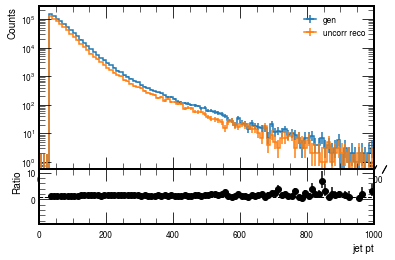

In [8]:
gen = hists_uncorr["gen", :, ::sum]
unc_reco = hists_uncorr["reco", :, ::sum]

fig = plt.gcf()
grid = fig.add_gridspec(2, 1, hspace=0, height_ratios=[3, 1])

main_ax = fig.add_subplot(grid[0])
subplot_ax = fig.add_subplot(grid[1], sharex=main_ax)

main, subplot = gen.plot_ratio(unc_reco, rp_num_label="gen", rp_denom_label="uncorr reco", ax_dict={'main_ax' : main_ax, 'ratio_ax': subplot_ax} )
main_ax.set_yscale('log')

#compare simulated jets (gen jets) and observed jets (reco)
# filters and selects only jets that fall within central part of the detector
# removing jets with low energy background noise


### Before and after JECs

Let's looks at some distributions to understand the difference in this correction:

In [10]:
#jerc_file = '/cvmfs/cms.cern.ch/rsync/cms-nanoAOD/jsonpog-integration/POG/JME/2018_UL/jet_jerc.json.gz'
jerc_file = '/cvmfs/cms-griddata.cern.ch/cat/metadata/JME/Run3-24Prompt-Winter24-NanoAODv14/2025-06-09/jet_jerc.json.gz'
jerc_corr = correctionlib.CorrectionSet.from_file(jerc_file)

uncorr_jets = copy.deepcopy(jets)
uncorr_jets['pt_raw'] = (1 - uncorr_jets['rawFactor']) * uncorr_jets['pt']
uncorr_jets['mass_raw'] = (1 - uncorr_jets['rawFactor']) * uncorr_jets['mass']
#uncorr_jets['rho'] = ak.broadcast_arrays(events.fixedGridRhoFastjetAll, uncorr_jets.pt)[0]
uncorr_jets['rho'] = ak.broadcast_arrays(events.Rho.fixedGridRhoFastjetAll, uncorr_jets.pt)[0]
j, nj = ak.flatten(uncorr_jets), ak.num(uncorr_jets)

#corr = jerc_corr.compound["Summer19UL18_V5_MC_L1L2L3Res_AK4PFchs"]
corr = jerc_corr.compound["Winter24Prompt24_V3_MC_L1L2L3Res_AK4PFPuppi"]
#flat_jec = corr.evaluate( j['area'], j['eta'], j['pt_raw'], j['rho'] )
flat_jec = corr.evaluate( j['area'], j['eta'], j['pt_raw'], j['rho'], j['phi'] )
jec = ak.unflatten( flat_jec, nj )

corr_jets = copy.deepcopy(uncorr_jets)
corr_jets['jet_energy_correction'] = jec
corr_jets['pt'] = corr_jets.pt_raw * jec
corr_jets['mass'] = corr_jets.mass_raw * jec

corr_jets = corr_jets[ (corr_jets.pt > 30) ]

Let's make the histograms to compare genjets with corrected jets:

In [11]:
hists_corr = (
    hist.Hist.new
    .StrCat(["gen", "reco"], name="jet_type")
    .Reg(100, 0, 1000, name="pt", label='jet pt')
    .Reg(40, -5, 5, name="eta", label='jet eta')
    .Weight()
    .fill(
        jet_type='gen',
        pt=ak.flatten(events.GenJet.pt),
        eta=ak.flatten(events.GenJet.eta)
    )
    .fill(
        jet_type='reco',
        pt=ak.flatten(corr_jets.pt),
        eta=ak.flatten(corr_jets.eta)
    )
)

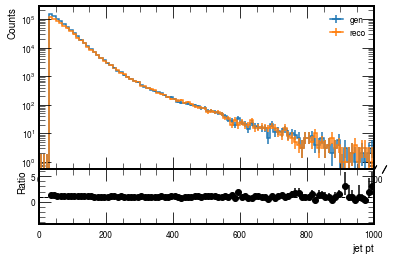

In [12]:
gen = hists_corr["gen",:,:].project("pt")
reco = hists_corr["reco",:,:].project("pt")

fig = plt.gcf()
grid = fig.add_gridspec(2, 1, hspace=0, height_ratios=[3, 1])

main_ax = fig.add_subplot(grid[0])
subplot_ax = fig.add_subplot(grid[1], sharex=main_ax)

main, subplot = gen.plot_ratio(reco, rp_num_label="gen", rp_denom_label="reco", ax_dict={'main_ax' : main_ax, 'ratio_ax': subplot_ax} )
main_ax.set_yscale('log')

#ratio plot is consistenly below 1 and descreases with increasing transverse momentum
# raw detecor underestimate the true jet measurment

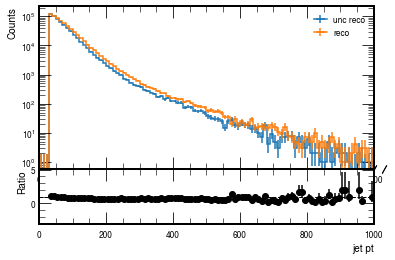

In [13]:
fig = plt.gcf()
grid = fig.add_gridspec(2, 1, hspace=0, height_ratios=[3, 1])

main_ax = fig.add_subplot(grid[0])
subplot_ax = fig.add_subplot(grid[1], sharex=main_ax)

main, subplot = unc_reco.plot_ratio(reco, rp_num_label="unc reco", rp_denom_label="reco", ax_dict={'main_ax' : main_ax, 'ratio_ax': subplot_ax} )
main_ax.set_yscale('log')


## Exercise 3.2: JEC Uncertainties

Let's apply the JEC uncertainties (one sigma up and down) to the uncorrected jets:

In [15]:
uncorr_jets = copy.deepcopy(jets)
uncorr_jets['pt_raw'] = (1 - uncorr_jets['rawFactor']) * uncorr_jets['pt']
uncorr_jets['mass_raw'] = (1 - uncorr_jets['rawFactor']) * uncorr_jets['mass']
#uncorr_jets['rho'] = ak.broadcast_arrays(events.fixedGridRhoFastjetAll, uncorr_jets.pt)[0]
uncorr_jets['rho'] = ak.broadcast_arrays(events.Rho.fixedGridRhoFastjetAll, uncorr_jets.pt)[0]
j, nj = ak.flatten(uncorr_jets), ak.num(uncorr_jets)

### jet corrections
#corr = jerc_corr.compound["Summer19UL18_V5_MC_L1L2L3Res_AK4PFchs"]
corr = jerc_corr.compound["Winter24Prompt24_V3_MC_L1L2L3Res_AK4PFPuppi"]
#flat_jec = corr.evaluate( j['area'], j['eta'], j['pt_raw'], j['rho'] )
flat_jec = corr.evaluate( j['area'], j['eta'], j['pt_raw'], j['rho'], j['phi'] )
jec = ak.unflatten( flat_jec, nj )

### jet corrections uncertainties
#corr = jerc_corr["Summer19UL18_V5_MC_Total_AK4PFchs"]
corr = jerc_corr["Winter24Prompt24_V3_MC_Total_AK4PFPuppi"]
flat_jec_unc = corr.evaluate( j['eta'], j['pt_raw'] )
flat_jec_unc_up = np.ones(len(j)) + flat_jec_unc
flat_jec_unc_down = np.ones(len(j)) - flat_jec_unc

jec_unc_up = ak.unflatten( flat_jec_unc_up, nj )
jec_unc_down = ak.unflatten( flat_jec_unc_down, nj )

corr_jets = copy.deepcopy(uncorr_jets)
corr_jets['jet_energy_correction'] = jec
corr_jets['pt'] = corr_jets.pt_raw * jec
corr_jets['mass'] = corr_jets.mass_raw * jec

corr_jets['pt_unc_up'] = corr_jets.pt_raw * jec * jec_unc_up
corr_jets['pt_unc_down'] = corr_jets.pt_raw * jec * jec_unc_down

corr_jets = corr_jets[ (corr_jets.pt > 30) ]

Let's make the plots to compare:

In [16]:
hists_unc = (
    hist.Hist.new
    .StrCat(["nominal", "up", 'down'], name="unc")
    .Reg(100, 0, 1000, name="pt", label='jet pt')
    .Weight()
    .fill(
        unc='nominal',
        pt=ak.flatten(corr_jets.pt),
    )
    .fill(
        unc='up',
        pt=ak.flatten(corr_jets.pt_unc_up),
    )
    .fill(
        unc='down',
        pt=ak.flatten(corr_jets.pt_unc_down),
    )
)

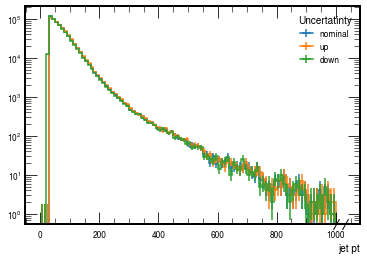

In [17]:
fig, ax = plt.subplots()
hists_unc.plot1d(ax=ax)
ax.legend(title="Uncertatinty")
ax.set_yscale("log")

## Your turn

You can check different the JEC uncertainties variations for other jet variables

## Exercise 3.3: Jet Energy Resolution

The next cell is the `coffea` implementation to apply jet energy resolution. Notice that this implementation does **not** uses the json-pog but the all txt files. 

This will change in the near future.

In [18]:
from coffea.jetmet_tools import FactorizedJetCorrector, JetCorrectionUncertainty
from coffea.jetmet_tools import JECStack, CorrectedJetsFactory
from coffea.lookup_tools import extractor

### just in case, let's start from scratch
events = NanoEventsFactory.from_root( fname, schemaclass=NanoAODSchema.v6).events()

ext = extractor()
ext.add_weight_sets([
    "* * ../../data/JECs/Summer19UL18_V5_MC/Summer19UL18_V5_MC_L1FastJet_AK4PFchs.txt",
    "* * ../../data/JECs/Summer19UL18_V5_MC/Summer19UL18_V5_MC_L2Relative_AK4PFchs.txt",
    "* * ../../data/JECs/Summer19UL18_V5_MC/Summer19UL18_V5_MC_L2L3Residual_AK4PFchs.txt",
    "* * ../../data/JECs/Summer19UL18_V5_MC/Summer19UL18_V5_MC_L3Absolute_AK4PFchs.txt",
    "* * ../../data/JECs/Summer19UL18_V5_MC/Summer19UL18_JRV2_MC_PtResolution_AK4PFchs.txt",
    "* * ../../data/JECs/Summer19UL18_V5_MC/Summer19UL18_JRV2_MC_SF_AK4PFchs.txt",
])
ext.finalize()

jec_stack_names = [
    "Summer19UL18_V5_MC_L1FastJet_AK4PFchs",
    "Summer19UL18_V5_MC_L2Relative_AK4PFchs",
    "Summer19UL18_V5_MC_L2L3Residual_AK4PFchs",
    "Summer19UL18_V5_MC_L3Absolute_AK4PFchs",
    "Summer19UL18_JRV2_MC_PtResolution_AK4PFchs",
    "Summer19UL18_JRV2_MC_SF_AK4PFchs"
]

evaluator = ext.make_evaluator()
jec_inputs = {name: evaluator[name] for name in jec_stack_names}
jec_stack = JECStack(jec_inputs)

name_map = jec_stack.blank_name_map
name_map['JetPt'] = 'pt'
name_map['JetMass'] = 'mass'
name_map['JetEta'] = 'eta'
name_map['JetA'] = 'area'

jets = events.Jet

jets['pt_raw'] = (1 - jets['rawFactor']) * jets['pt']
jets['mass_raw'] = (1 - jets['rawFactor']) * jets['mass']
jets['pt_gen'] = ak.values_astype(ak.fill_none(jets.matched_gen.pt, 0), np.float32)
#jets['rho'] = ak.broadcast_arrays(events.fixedGridRhoFastjetAll, jets.pt)[0]
jets['rho'] = ak.broadcast_arrays(events.Rho.fixedGridRhoFastjetAll, jets.pt)[0]
name_map['ptGenJet'] = 'pt_gen'
name_map['ptRaw'] = 'pt_raw'
name_map['massRaw'] = 'mass_raw'
name_map['Rho'] = 'rho'

events_cache = events.caches[0]
jet_factory = CorrectedJetsFactory(name_map, jec_stack)
corrected_jets = jet_factory.build(jets, lazy_cache=events_cache)

Keep in mind that JERs needs to be applied in uncorrected jets. All of this is done behind the scene with the `coffea` `CorrectedJetsFactory`. 

Now let's look at the effect in the jet pt and plot the difference in the JER variations:

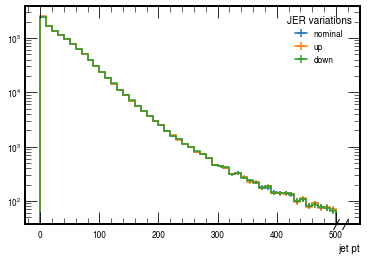

In [19]:
fig, ax = plt.subplots()

hists_jer = (
    hist.Hist.new
    .StrCat(["nominal", "up", 'down'], name="unc", label="JER")
    .Reg(50, 0, 500, name="pt", label='jet pt')
    .Weight()
    .fill(
        unc='nominal',
        pt=ak.flatten(corrected_jets.pt),
    )
    .fill(
        unc='up',
        pt=ak.flatten(corrected_jets.JER.up.pt),
    )
    .fill(
        unc='down',
        pt=ak.flatten(corrected_jets.JER.down.pt),
    )
).plot1d()
ax.legend(title="JER variations")
ax.set_yscale("log")

In [20]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import hist
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import uproot
from math import pi

# --- CORRECTED LINE: Using the XRootD path for reliable access in SWAN ---
# The standard XRootD server for CMS data is used here.
file_path = "root://cmsxrootd.fnal.gov///store/user/cmsdas/2025/short_exercises/muons/DYtoMuMu.root"

# Open the file and the 'Events' TTree
events = uproot.open(file_path)['Events']

# Now check the keys to ensure the file was opened correctly
print("Successfully opened file. Available branches (keys):")
print(events.keys())
#events.values()
#events.show()

n_events = 10000

muon_pt,muon_eta,muon_phi,nmuon,ngenpart=events.arrays(["Muon_pt", "Muon_eta", "Muon_phi", "nMuon", "nGenPart"],entry_stop = n_events, library="ak",how=tuple)
print('muon_pt=', muon_pt, '\n',
      'muon_eta=', muon_eta, '\n',
      'muon_phi=', muon_phi)
plt.figure(figsize=(9,6))
plt.hist(ak.flatten(muon_pt), bins=150, range=[0,150], histtype='step',linewidth=2, color='blue', label='$p_T$ distribution of all Muons')
plt.title('$p_T$ distribution of PAT Muon objects')
plt.xlabel(r'Muon $p_T$ (GeV)')
plt.ylabel('Events')

OSError: XRootD error: [ERROR] Operation expired
in file root://cmsxrootd.fnal.gov///store/user/cmsdas/2025/short_exercises/muons/DYtoMuMu.root